In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [24]:
data = pd.read_csv(r'./maps/FVG/FVG_companies.csv', dtype='str')
data.columns = ['ind', 'cf', 'company','unit', 'lat', 'lon']
data = data[ ['lon','lat'  ] ]
data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data.shape

(7955, 2)

In [7]:
def plot_clusters(X, cluster_labels, centroids):
    _, ax = plt.subplots(figsize=(6, 6))
    for i in np.unique(cluster_labels):
        cluster_points = X[cluster_labels == i , :]        
        centroid = centroids[i , :]
        plt.scatter(cluster_points[:,0] , cluster_points[:,1] , cmap = i, marker='.')
        plt.scatter(centroid[0] , centroid[1] , c = 'black', marker='*', s=60)  

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Visualization of clustered data', fontweight='bold')
    ax.set_aspect('equal')
    plt.show

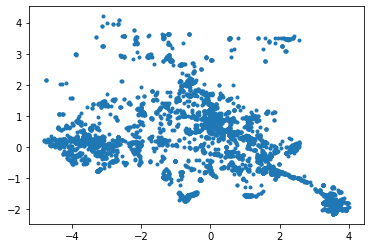

In [58]:
X = np.array(data) 
X = (X - X.mean(axis=0))#/X.std()
X = X * 100 # arbitrary rescaling
plt.scatter(X[:,0] , X[:,1] ,  marker='.')


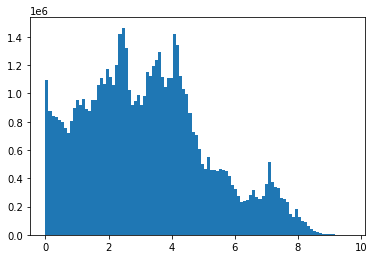

In [64]:
#compute the minimum distances of the k-th nearest neighbour
from scipy.spatial import distance_matrix
dm = distance_matrix(X,X)
values = np.reshape(dm,-1)
plt.hist(values, bins = 100)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

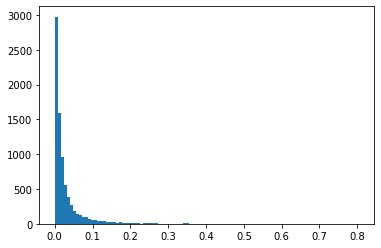

In [65]:
knn = 5
min_distances= np.partition(dm, knn, axis=0)[knn] 
plt.hist(min_distances, bins = 100)
plt.show

In [66]:
for p in range(10,100,10):
    print(f"il {p}° percentile ==> distanza {np.percentile(min_distances, p)}")

il 10° percentile ==> distanza 0.0
il 20° percentile ==> distanza 0.003868904963141042
il 30° percentile ==> distanza 0.006132700849856482
il 40° percentile ==> distanza 0.00895115988084529
il 50° percentile ==> distanza 0.012759409635230187
il 60° percentile ==> distanza 0.01779280182502902
il 70° percentile ==> distanza 0.02467818442792796
il 80° percentile ==> distanza 0.03740352486409
il 90° percentile ==> distanza 0.07036251123530277


In [81]:
#radius of the circle 
eps = 0.1

#minimum neighbouring points set to 3
minPts = 15

data = pd.DataFrame(X, columns = ["X", "Y"] )
clustered = cluster_with_stack(data, eps, minPts)

In [82]:
idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])
cluster_labels = cluster_df["cluster"]
np.unique(cluster_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

Text(0, 0.5, 'Y')

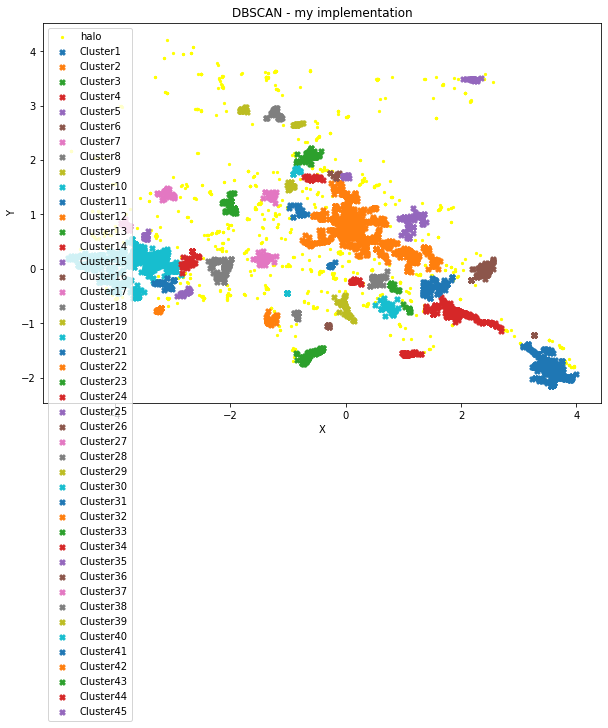

In [83]:


plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    if clust == 0: 
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
                    X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
                    s=20, marker = ".", color = "yellow",
                    label="halo")
    else:
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
            X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
            s=30, marker = "X", 
            label=f"Cluster{clust}")


#plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.legend()
plt.title('DBSCAN - my implementation')
plt.xlabel('X')
plt.ylabel('Y')


# my DBSCAN class


In [106]:
class DBSCANClustering():
    def __init__(self, X,  epsilon=.01, minPoints = 15 ):
        assert epsilon > 0 
        self.epsilon = epsilon
        assert minPoints > 2
        self.minPoints = minPoints
        self.n_points = X.shape[0]
        self.dimensions = X.shape[1]
        
    def is_core(self,index):
        """
        Args:
            df (pandas dataframe): data points
            index (int): index of the point to be classified
           
        Returns:
            tuple: dataframe (index, is_core, is_border, is_noise)
        """
        distances = self.dm[index]
        neighbours_indices = np.argpartition(distances, self.minPoints, axis=0)[:self.minPoints] 
        
        neighbours = distances[neighbours_indices]
        neighbours_within_epsilon = neighbours[ neighbours < self.epsilon]
        
        if len(neighbours_within_epsilon) == 0: 
            # is halo
            return (neighbours_indices , False, False, True)
        elif len(neighbours_within_epsilon) >= self.minPoints: 
            # is core
            return (neighbours_indices , True, False, False)
        else:
            # is border
            return (neighbours_indices , False, True, False)
        
    
    def fit(self,X):
        """_summary_

        Args:
            X (np.array): data points

        Returns:
            clusters (np.array): labels (halo = 0; clusters numbered from 1)
        """
        # compute distance matrix for ALL points
        # simple but not optimized for memory: stores the whole matrix.
        from scipy.spatial import distance_matrix
        self.dm = distance_matrix(X,X)
        
        # initialize all points to halo (label = 0)
        self.clusters = np.zeros(self.n_points) 
        C = 1
        
        current_stack = set()
        unvisited = list(np.arange(self.n_points))#list(df.index)
        clusters = []
        
        while (len(unvisited) > 0): #run until all points have been visited

            #identifier for first point of a cluster
            first_point = True
            
            #choose a random unvisited point
            current_stack.add(random.choice(unvisited))
                        
            while len(current_stack) > 0: #run until a cluster is complete
                
                #pop current point from stack
                curr_idx = current_stack.pop()
                              
                #check if point is core, neighbour or border
                neigh_indexes, iscore, isborder, isnoise = self.is_core(curr_idx)
                
                #dealing with an edge case
                if (isborder & first_point):
                    #for first border point, we label it aand its neighbours as noise 
                    clusters.append((curr_idx, 0))
                    clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                    
                    #label as visited
                    unvisited.remove(curr_idx)
                    unvisited = [e for e in unvisited if e not in neigh_indexes]
        
                    continue
                    
                unvisited.remove(curr_idx) #remove point from unvisited list
                
                
                neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
                
                if iscore: #if current point is a core
                    first_point = False
                    
                    clusters.append((curr_idx,C)) #assign to a cluster
                    current_stack.update(neigh_indexes) #add neighbours to a stack

                elif isborder: #if current point is a border point
                    clusters.append((curr_idx,C))
                    
                    continue

                elif isnoise: #if current point is noise
                    clusters.append((curr_idx, 0))
                    
                    continue
                    
            if not first_point:
                #increment cluster number
                C+=1
                print(C)
        self.clusters = clusters
        return clusters
        

In [113]:
clusters_with_halo = DBSCANClustering(X, epsilon=eps, minPoints = 30 )
cc = clusters_with_halo.fit(X)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [114]:
cluster_df = pd.DataFrame(cc, columns = ["idx", "cluster"])
cluster_labels1 = cluster_df["cluster"]
np.unique(cluster_labels1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int64)

Text(0, 0.5, 'Y')

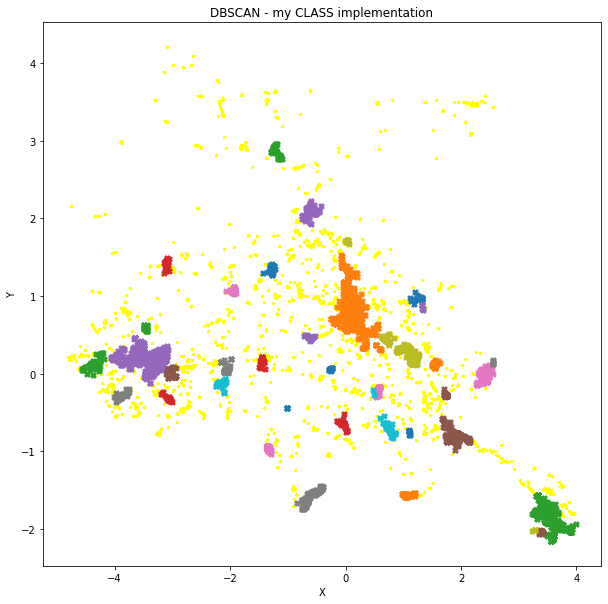

In [116]:


plt.figure(figsize=(10,10))
for clust in np.unique(cluster_labels1):
    if clust == 0: 
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
                    X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
                    s=20, marker = ".", color = "yellow",
                    label="halo")
    else:
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
            X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
            s=30, marker = "X", 
            label=f"Cluster{clust}")


#plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
#plt.legend()
plt.title('DBSCAN - my CLASS implementation')
plt.xlabel('X')
plt.ylabel('Y')

# Clustering with SKLearn

In [117]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=eps, min_samples=minPts).fit(X)
clustering.labels_



array([-1, -1, -1, ..., -1,  6, 10], dtype=int64)

In [118]:
print(np.unique(clustering.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53]


Text(0, 0.5, 'Y')

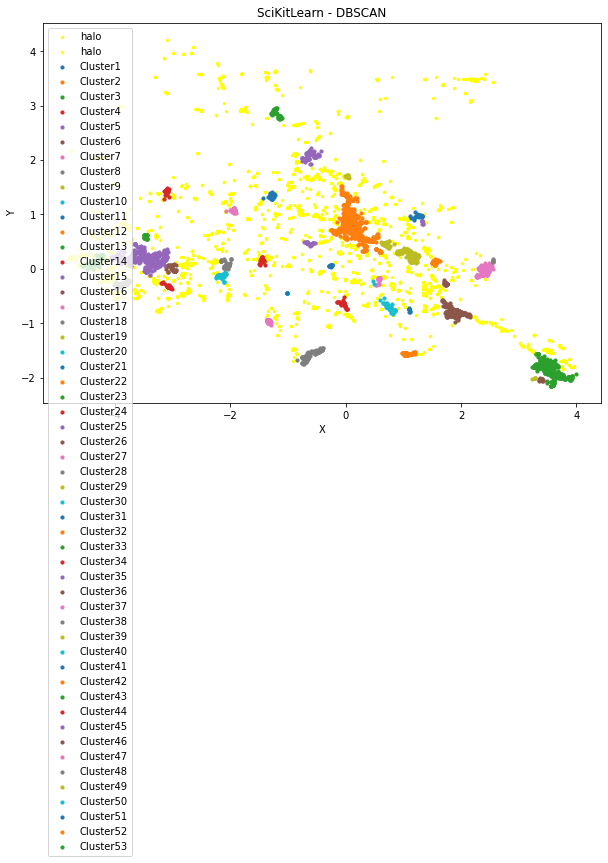

In [120]:
plt.figure(figsize=(10,7))
for clust in np.unique(clustering.labels_):
    if clust <1: 
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
                    X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
                    s=20, marker = ".", color = "yellow",
                    label="halo")
    else:
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
            X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
            s=10, marker = "o", 
            label=f"Cluster{clust}")


#plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.legend()
plt.title('SciKitLearn - DBSCAN')
plt.xlabel('X')
plt.ylabel('Y')